In [1]:
import matplotlib.pyplot as plt
import requests
import numpy as np
import pandas as pd
import pandas_ta as ta
from datetime import datetime
from binance.client import Client
client = Client()

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

import math
from sklearn.metrics import mean_squared_error

In [2]:
startDate = '2022-01-01 00:00:00'
testDate  = '2024-06-01 00:00:00'
r = client.get_historical_klines('BTCUSDT','1h',startDate)

In [3]:
df = pd.DataFrame(r)
colnames = ['openTime','openPrice','highPrice','lowPrice','closePrice','volume','closeTime','quoteAssetVolume','NumberOfTrades','TakerBaseVolume','TakerQuoteVolume','Ignore']
df.columns = colnames
df['closeTime'] = pd.to_datetime(df['closeTime'], unit='ms')
df = df.astype({'closePrice':'float','openPrice':'float','highPrice':'float','lowPrice':'float','volume':'float'})
df['return'] = df['closePrice'].pct_change()
df['return_next'] = df['return'].shift(-1).fillna(0)
df['predict'] = 1
df.set_index("closeTime", inplace= True)
df.head(2)

,openTime,openPrice,highPrice,lowPrice,closePrice,volume,quoteAssetVolume,NumberOfTrades,TakerBaseVolume,TakerQuoteVolume,Ignore,return,return_next,predict
closeTime,,,,,,,,,,,,,,
2022-01-01 00:59:59.999,1640995200000,46216.93,46731.39,46208.37,46656.13,1503.33095,69879986.39049930,38608,806.06536000,37462156.91764400,0,NaN,0.002615,1
2022-01-01 01:59:59.999,1640998800000,46656.14,46949.99,46574.06,46778.14,943.81539,44127148.11760220,31872,491.18067000,22963272.85537420,0,0.002615,0.000719,1


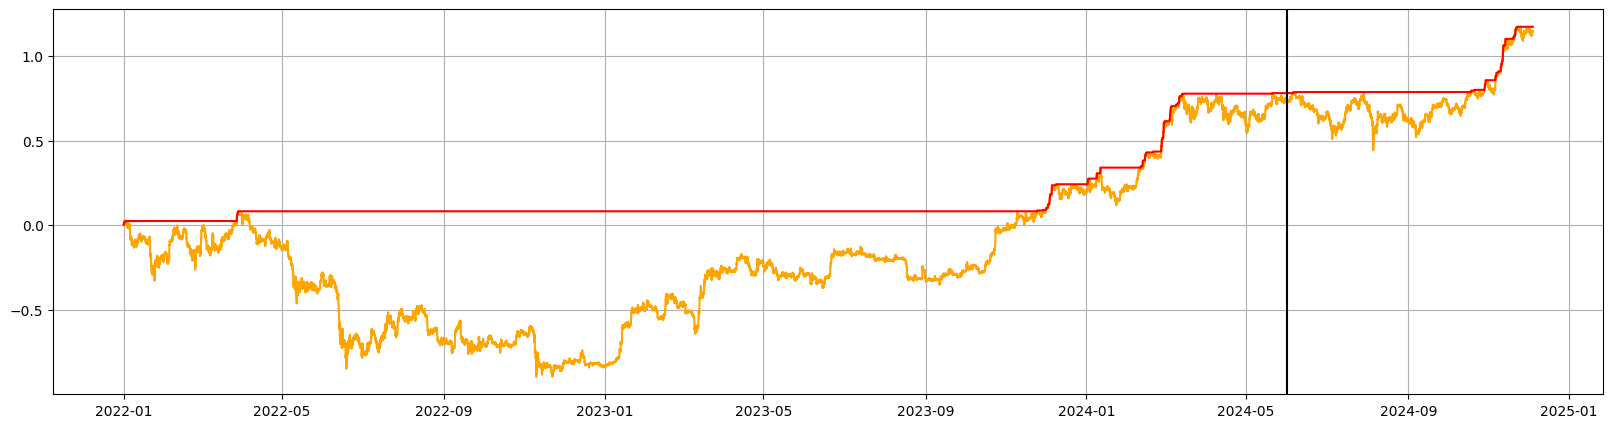

In [4]:
def func_plot(df):
  df['pnl'] = df['return_next'] * df['predict']
  df['pnl_cumsum'] = df['pnl'].cumsum()
  df['pnl_cumsum_max'] = df['pnl_cumsum'].cummax()
  df['pnl_dd'] = df['pnl_cumsum_max'] - df['pnl_cumsum']
  plt.figure(figsize=(20,5))
  plt.plot(df['pnl_cumsum'],color='orange')
  plt.plot(df['pnl_cumsum_max'],color='red')
  plt.axvline(x = pd.to_datetime(testDate), color='black')
  plt.grid()
  plt.show()

func_plot(df)

In [5]:
look_back = 60 # choose sequence length

train = df[(df.index<testDate)].reindex()
X_train = train[['closePrice']]

X_train=X_train.fillna(method='ffill')
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train['closePrice'] = scaler.fit_transform(X_train['closePrice'].values.reshape(-1,1))
print('x_train.shape = ',X_train.shape)
X_train=X_train[['closePrice']]

data_raw = X_train.values # convert to numpy array
data = []

# create all possible sequences of length look_back
for index in range(len(data_raw) - look_back): 
    data.append(data_raw[index: index + look_back])

data = np.array(data);

X_train = data[:,:-1,:]
y_train = data[:,-1,:]

print('x_train.shape = ',X_train.shape)
print('y_train.shape = ',y_train.shape)

# make training and test sets in torch
X_train = torch.from_numpy(X_train).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)

x_train.shape =  (21167, 1)
x_train.shape =  (21107, 59, 1)
y_train.shape =  (21107, 1)


C:\Users\Mirom\AppData\Local\Temp\ipykernel_18712\44012792.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_train=X_train.fillna(method='ffill')


In [ ]:
# Build model
#####################
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1

# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())
    
# Train model
#####################
num_epochs = 60
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(X_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])
Epoch  10 MSE:  0.11781333386898041
Epoch  20 MSE:  0.027718769386410713


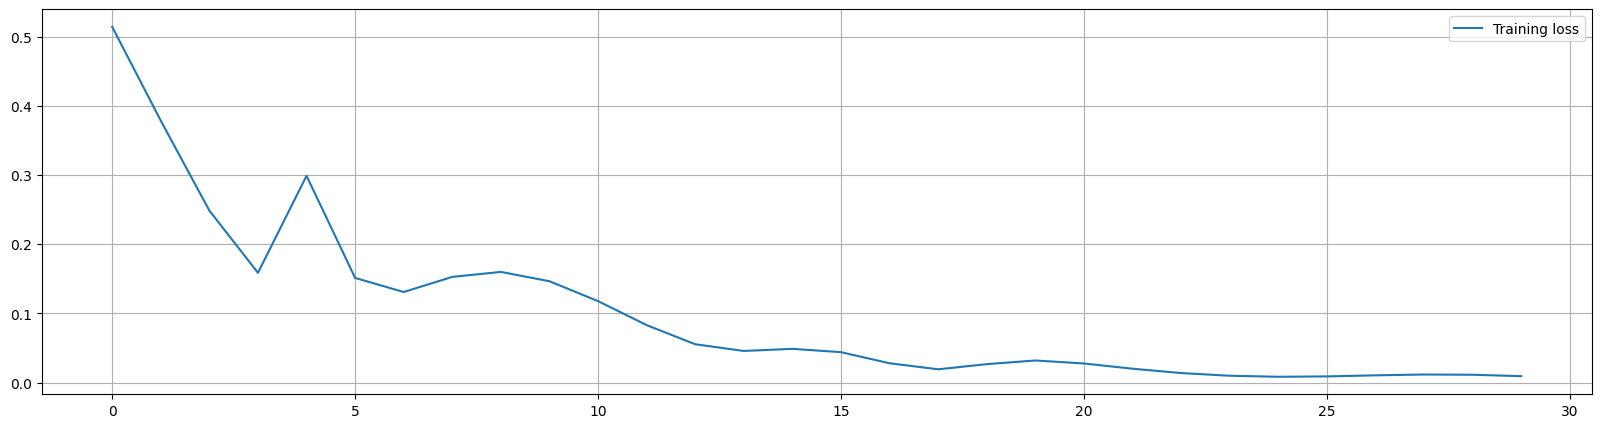

In [7]:
plt.figure(figsize=(20,5))
plt.plot(hist, label="Training loss")
plt.grid()
plt.legend()
plt.show()

In [8]:
np.shape(y_train_pred)

torch.Size([21107, 1])

In [9]:
test = df
X_test = test[['closePrice']]

X_test=X_test.fillna(method='ffill')
scaler = MinMaxScaler(feature_range=(-1, 1))
X_test['closePrice'] = scaler.fit_transform(X_test['closePrice'].values.reshape(-1,1))
print('X_test.shape = ',X_test.shape)
X_test=X_test[['closePrice']]

data_raw = X_test.values # convert to numpy array
data = []

# create all possible sequences of length look_back
for index in range(len(data_raw) - look_back): 
    data.append(data_raw[index: index + look_back])

data = np.array(data);

X_test = data[:,:-1,:]
y_test = data[:,-1,:]

print('X_test.shape = ',X_test.shape)
print('y_test.shape = ',y_test.shape)

# make training and test sets in torch
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

X_test.shape =  (25640, 1)
X_test.shape =  (25580, 59, 1)
y_test.shape =  (25580, 1)


C:\Users\Mirom\AppData\Local\Temp\ipykernel_18712\2510474396.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test=X_test.fillna(method='ffill')


In [10]:
# make predictions
y_test_pred = model(X_test)

# invert predictions
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 3342.45 RMSE


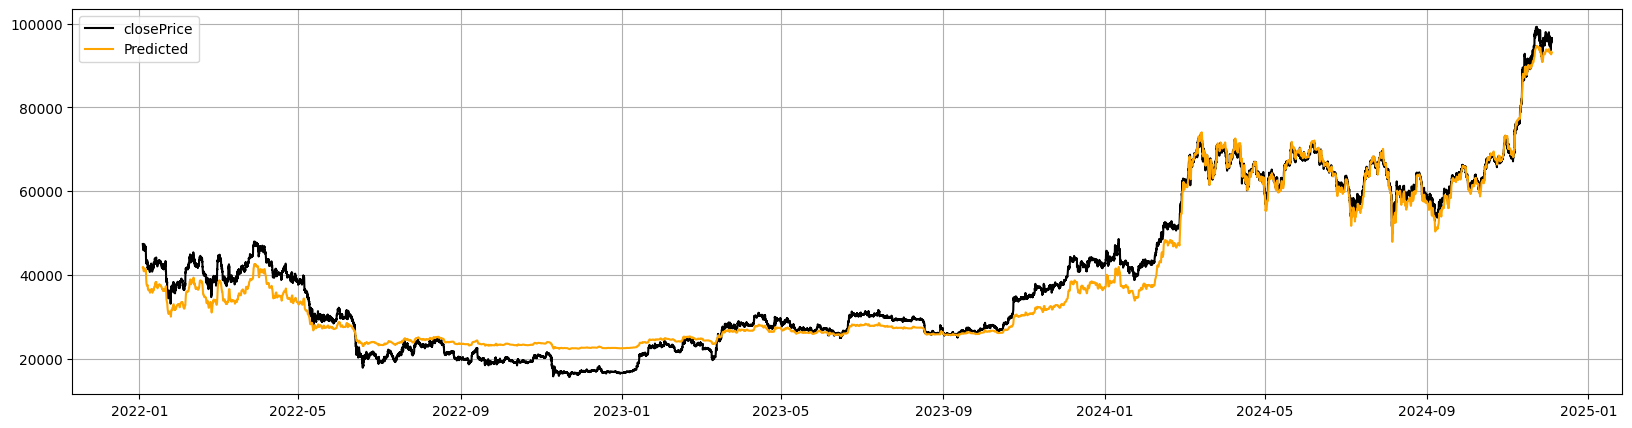

In [11]:
# Visualising the results
figure, axes = plt.subplots(figsize=(20, 5))
axes.xaxis_date()
axes.plot(df[look_back:].index, y_test, color = 'black', label = 'closePrice')
axes.plot(df[look_back:].index, y_test_pred, color = 'orange', label = 'Predicted')
plt.grid()
plt.legend()
plt.show()

In [12]:
dfTest = pd.DataFrame(y_test)
dfTest.index = df[look_back:].index
dfTest['closeTimePred'] = ''
dfTest['closeTimePred'] = y_test_pred.tolist()
dfTest['closeTimePred'] = dfTest['closeTimePred'].str[0]
dfTest = dfTest.reset_index()
dfTest = dfTest.set_axis(['closeTime','closePrice','closeTimePred'], axis=1)
dfTest['closeTime'] = pd.to_datetime(dfTest['closeTime'], unit='ms')
dfTest['return_next'] = dfTest['closePrice'].pct_change()
dfTest['predict'] = dfTest['closeTimePred'].pct_change()
dfTest['pnl'] = dfTest['return_next'] * dfTest['predict']
dfTest=dfTest.set_index('closeTime')

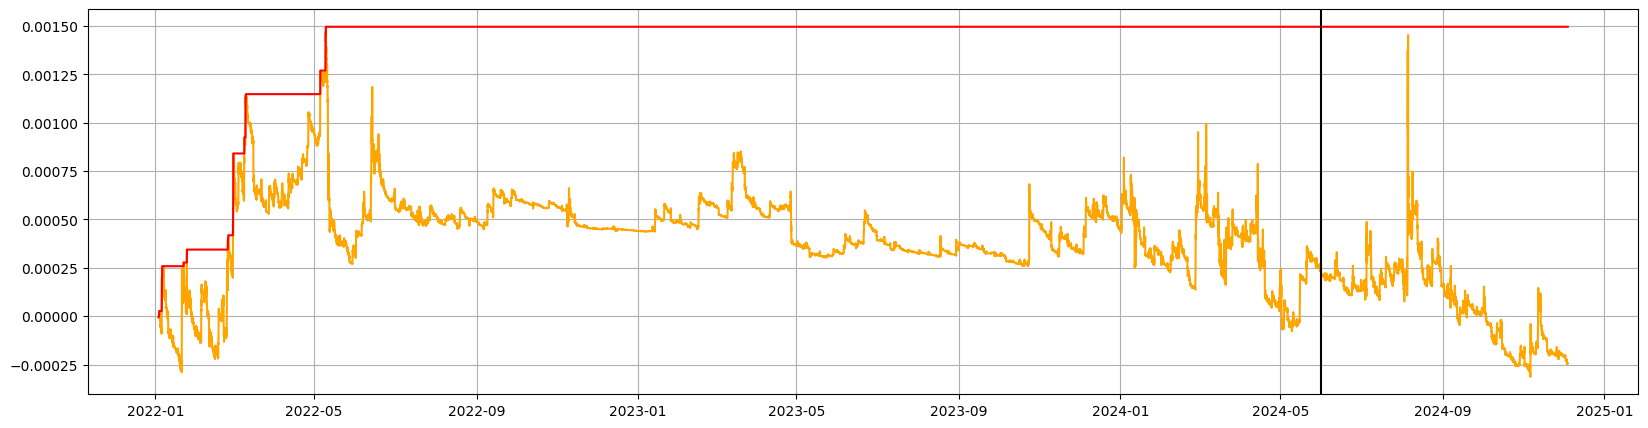

            train     test
PNL      : 0.000216   -0.00046  
MDD      : 0.001574   0.00181   
Sharpe   : 0.13723    -0.254144 


In [13]:
def func_plot(df):
  df['pnl'] = df['return_next'] * df['predict']
  df['pnl_cumsum'] = df['pnl'].cumsum()
  df['pnl_cumsum_max'] = df['pnl_cumsum'].cummax()
  df['pnl_dd'] = df['pnl_cumsum_max'] - df['pnl_cumsum']
  plt.figure(figsize=(20,5))
  plt.plot(df['pnl_cumsum'],color='orange')
  plt.plot(df['pnl_cumsum_max'],color='red')
  plt.axvline(x = pd.to_datetime(testDate), color='black')
  plt.grid()
  plt.show()

func_plot(dfTest)

def func_model_performance(df):
  train = df[(df.index<testDate)].reindex()
  test = df[(df.index>=testDate)].reindex()

  pnl_train = round(train['pnl'].sum(),6)
  pnl_test = round(test['pnl'].sum(),6)

  mdd_train = round(train['pnl_dd'].max(),6)
  mdd_test = round(test['pnl_dd'].max(),6)

  sharpe_train = round(pnl_train/mdd_train,6)
  sharpe_test = round(pnl_test/mdd_test,6)

  print('            train     test')
  print('PNL      : {0: <10}'.format(pnl_train),'{0: <10}'.format(pnl_test))
  print('MDD      : {0: <10}'.format(mdd_train),'{0: <10}'.format(mdd_test))
  print('Sharpe   : {0: <10}'.format(sharpe_train),'{0: <10}'.format(sharpe_test))
  return sharpe_train
sharpe = func_model_performance(dfTest)